In [1]:
import os


if 'tfg' not in os.listdir():
    os.chdir('..')

In [2]:
from tfg.alphaZero import create_alphazero
from tfg.alphaZeroCallbacks import Checkpoint
from tfg.alphaZeroAdapters import TicTacToeAdapter
from tfg.util import enable_gpu
from tfg.alphaZeroConfig import AlphaZeroConfig
from game.tictactoe import TicTacToe

import time

In [3]:
enable_gpu()

game = TicTacToe()

In [4]:
config = AlphaZeroConfig(
    learning_rate=.01,
    regularizer_constant=.0,
    residual_layers=1,
    filters=32,
    kernel_size=(3, 3)
)

start = time.time()

alphazero = create_alphazero(game, TicTacToeAdapter(), max_workers=10,
                             self_play_times=120, max_games_counter=600,
                             buffer_size=1500, batch_size=1024, temperature=100,
                             epochs=5, c_puct=1, exploration_noise=(.25, .045),
                             mcts_iter=200, nn_config=config)

print("Finished training after", time.time() - start, "seconds")

2021-05-11 18:43:47,130	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


Epoch 1/5
31/31 - 4s - loss: 1.3734 - value_head_loss: 0.5678 - policy_head_loss: 2.1791
Epoch 2/5
31/31 - 0s - loss: 1.2406 - value_head_loss: 0.5005 - policy_head_loss: 1.9806
Epoch 3/5
31/31 - 0s - loss: 1.1660 - value_head_loss: 0.4627 - policy_head_loss: 1.8692
Epoch 4/5
31/31 - 0s - loss: 1.1180 - value_head_loss: 0.4588 - policy_head_loss: 1.7772
Epoch 5/5
31/31 - 0s - loss: 1.0818 - value_head_loss: 0.4464 - policy_head_loss: 1.7172
Games played: 120
Epoch 1/5
32/32 - 1s - loss: 0.9466 - value_head_loss: 0.3144 - policy_head_loss: 1.5788
Epoch 2/5
32/32 - 0s - loss: 0.8436 - value_head_loss: 0.2891 - policy_head_loss: 1.3981
Epoch 3/5
32/32 - 0s - loss: 0.8146 - value_head_loss: 0.2875 - policy_head_loss: 1.3417
Epoch 4/5
32/32 - 0s - loss: 0.7852 - value_head_loss: 0.2733 - policy_head_loss: 1.2972
Epoch 5/5
32/32 - 0s - loss: 0.7663 - value_head_loss: 0.2649 - policy_head_loss: 1.2677
Games played: 240
Epoch 1/5
32/32 - 0s - loss: 0.6215 - value_head_loss: 0.1731 - policy_hea

In [5]:
alphazero.save('models/TicTacToe_copy.h5')

In [1]:
import os


if 'tfg' not in os.listdir():
    os.chdir('..')
    
from tfg.strategies import Minimax, MonteCarloTree
from tfg.alphaZero import parallel_play
from tfg.alphaZeroAdapters import TicTacToeAdapter
from tfg.util import enable_gpu,play
from game.tictactoe import TicTacToe

In [2]:
enable_gpu()

game = TicTacToe()
minimax = Minimax(game)

In [5]:
parallel_play(game, TicTacToeAdapter(), Minimax(game),
              'models/TicTacToe_copy.h5', 'black', max_workers=10,
              mcts_iter=2, games=100)

(2, 98, 0)

In [4]:
parallel_play(game, TicTacToeAdapter(), Minimax(game),
              'models/TicTacToe_copy.h5', 'black', max_workers=10,
              mcts_iter=200, games=100)

(0, 100, 0)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tfg.alphaZero import AlphaZero

def plot_token(i, j, token, color=None, linewidth=4):
    if color is None:
        color = 'k'
    if linewidth is None:
        linewidth = 4
    
    if token == WHITE:
        x = [j + .2, j + .8]
        y = [2 - i + .2, 2 - i + .8]
        plt.plot(x, y, linewidth=linewidth, c=color)
        plt.plot(x, y[::-1], linewidth=linewidth, c=color)
    elif token == BLACK:
        circle = plt.Circle((j + .5, 2 - i + .5), .35, color=color, linewidth=linewidth, fill=False)
        plt.gca().add_patch(circle)

def plot_board(board, value=None, probabilities=None, alpha=1, cmap='winter', color=None, linewidth=None):
    fig = plt.gcf()
    
    if probabilities is not None:
        probs = probabilities.reshape(3, 3)
        plt.imshow(probs, cmap=cmap, extent=[0, 3, 0, 3], alpha=alpha)
        plt.clim(0, 1)
        plt.colorbar()
    
    plt.gca().set_axis_off()
    
    for i in (1, 2):
        plt.plot([i, i], [0, 3], 'k', linewidth=4)
        plt.plot([0, 3], [i, i], 'k', linewidth=4)
        
    for i in range(3):
        for j in range(3):
            plot_token(i, j, board[i, j], color, linewidth)
            if probabilities is not None:
                plt.text(j + .5, 2 - i + .5, f'{probs[i, j]:.3f}', fontsize=14,
                         color='w', weight='bold', ha='center', va='center')
    
    if value is not None:
        ax = fig.axes[0]
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height + .043])
        ax = fig.add_axes([pos.x0 + .015, pos.y0 - .07, .488, .036])
        cmap = mpl.colors.ListedColormap(['w', 'k'])
        bounds = [-1, value, 1]
        ticks = [-1, 1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        mpl.colorbar.ColorbarBase(
            ax, cmap=cmap,
            norm=norm,
            boundaries=bounds,
            ticks=ticks,
            spacing='proportional',
            orientation='horizontal'
        )
        ax.plot([0, 0], [-1, 1], 'gray')
        ha, c = ('left', 'w') if value < 0 else ('right', 'k')
        ax.text(value, -.22, f'{value:.3f}', ha=ha, va='center', c=c, fontsize=10, weight='bold')
    
    return fig

In [10]:
adapter = TicTacToeAdapter()
az = AlphaZero(game, adapter)
az.load('models/TicTacToe_copy.h5')
model = az.neural_network.model

In [11]:
from tfg.games import WHITE, BLACK


# Make arrays more visual
X = WHITE
O = BLACK
_ = 0


boards = np.array([
    [[_, _, _],
     [_, _, _],
     [_, _, _]],
    
    [[X, O, _],
     [_, _, _],
     [_, _, _]],
    
    [[X, O, O],
     [_, X, _],
     [_, _, _]],
    
    [[X, O, O],
     [_, X, _],
     [_, _, X]],
    
    [[X, X, O],
     [_, O, X],
     [_, _, _]],
    
    [[O, _, O],
     [X, O, X],
     [_, _, X]],
    
    [[X, O, X],
     [X, O, O],
     [_, X, _]],
    
    [[O, _, _],
     [_, X, _],
     [_, _, X]]
])

turns = [WHITE if board.sum() == 0 else BLACK for board in boards]

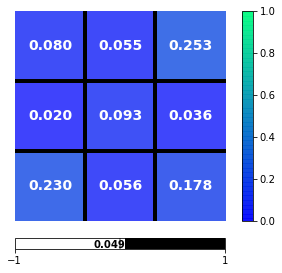

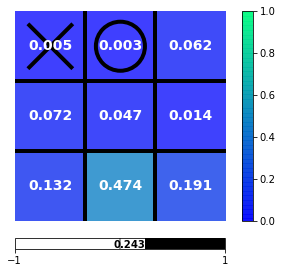

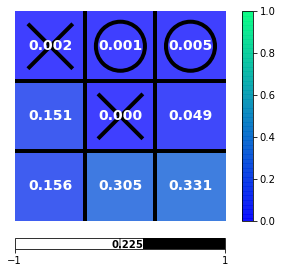

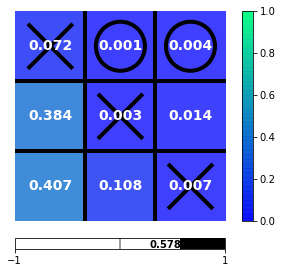

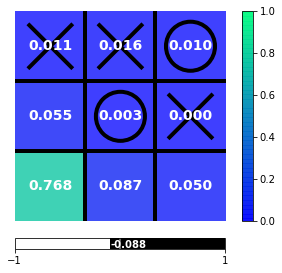

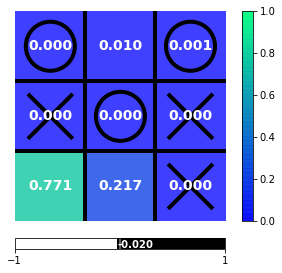

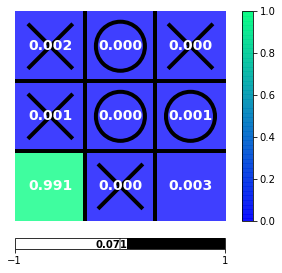

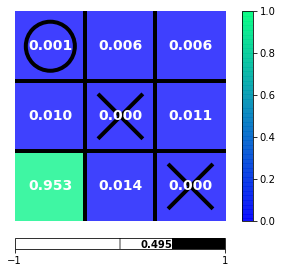

In [12]:
nn_input = np.stack([adapter.to_input(board, to_play)
                     for board, to_play in zip(boards, turns)])
values, probabilities = model(nn_input)
values = values.numpy().reshape(-1) * np.array(turns)
probabilities = probabilities.numpy()
for i, (board, value, probs) in enumerate(zip(boards, values, probabilities)):
    fig = plot_board(board, value, probs, alpha=.75)
    plt.gcf().subplots_adjust(bottom=.15)
    plt.show()